Using CPU
fatal: destination path 'echocardiography' already exists and is not an empty directory.
Number of Image in train set: 6717
Number of Image in test set: 1607
Classes:  ['2C', '3C', '4C']
Num batch in train set:  210
image size:  torch.Size([3, 224, 224])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


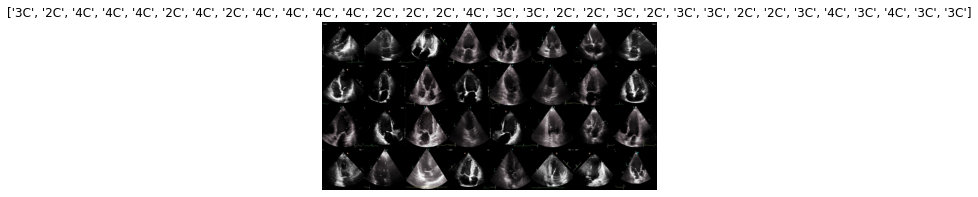

In [40]:

# Import Library
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision
from torchvision import models,transforms
from torchvision.datasets import ImageFolder

from collections import namedtuple

from sklearn.metrics import classification_report

import time
import os
import copy

# Using CUDA
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
else: print("Using CPU")


# Clone Data
!git clone https://github.com/qcuong103/echocardiography

image_datasets = namedtuple('imagedatasets', 
                            ['train', 'test'])
# Hyper-parameters
num_classes = 3
classes = ['2C', '3C', '4C']

# Prepare Data
# Transforms Data
train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),                                
    transforms.ToTensor(),
])
test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
])
trainset = torchvision.datasets.ImageFolder(
    root='/content/echocardiography/DATA_CHAMBER_2021/train', 
    transform=train
)
testset = torchvision.datasets.ImageFolder(
    root='/content/echocardiography/DATA_CHAMBER_2021/test', 
    transform=test
)
print("Number of Image in train set:", len(trainset))
print("Number of Image in test set:", len(testset))
print("Classes: ", classes)

# Load Data
datasets=image_datasets(train=trainset, test=testset)

batch = 32
worker = 4
trainloader = DataLoader(
    dataset=datasets.train, batch_size=batch, 
    shuffle=True, num_workers=worker
)
testloader = DataLoader(
    dataset=datasets.test, batch_size=batch, 
    shuffle=True, num_workers=worker
)
print("Num batch in train set: ", len(trainloader))
loaders=image_datasets(train=trainloader, test=testloader)

print("image size: ", datasets.train[0][0].shape)
class_names = trainset.classes
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# **Train**

In [41]:
def train_epoch(epoch, model, loader, loss_func, optimizer, device):
  model.train()

  images_so_far = 0.0
  reporting_steps = 20
  step = 0

  for images, labels in loader:
    step += 1
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)

    loss = loss_func(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    images_so_far += loss.item()
    if step % reporting_steps == reporting_steps - 1:
      print(f"Epoch {epoch} step {step} ave_loss {images_so_far/reporting_steps:.4f}")
      images_so_far = 0.0


# **Test**

In [42]:
def test_epoch(epoch, model, loader, device):
  vid_id = []
  since = time.time()
  y_true = []
  y_pred = []

  with torch.no_grad():
    model.eval()
    for images, labels in loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, dim=1)
      
      y_true += list(labels.cpu().numpy())
      y_pred += list(predicted.cpu().numpy())

  elapsed_time = time.time() - since
  print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
  print('-' * 10)

  return y_pred, y_true

# **Main**

In [43]:
def run(model='vgg16'):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  use_pretrained = False

  print("model:", model)

  if model == 'vgg16':
    PATH='./vgg16.pth'  
    model = models.vgg16(pretrained=use_pretrained)
    model.classifier[6] = nn.Linear(in_features=4096, out_features=3)
  elif model == 'vgg19':
    PATH='./vgg19.pth'
    model = models.vgg19()
    model.classifier[6] = nn.Linear(in_features=4096, out_features=3)
  elif model == 'resnet50':
    PATH='./resnet50.pth'
    model = models.resnet50()
    model.classifier[6] = nn.Linear(in_features=2048, out_features=3) 
  else:
    PATH='./resnet18.pth'
    model = models.resnet18()
    model.classifier[6] = nn.Linear(in_features=512, out_features=3) 

  model.to(device)
  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

  accuracies = []
  for epoch in range(10):
    print("---------------------------------------------------------------")
    print(f"\nEpoch {epoch} report: ")
    train_epoch(epoch, model, loaders.train, loss_func, optimizer, device)
    pred_test, true_test = test_epoch(epoch, model, loaders.test, device)
    print("Test report: \n", classification_report(true_test, pred_test, target_names=classes))
    torch.save(model.state_dict(), PATH)

  return model

# **Run**

In [ ]:
#Model VGG16
result_VGG16 = run(model='vgg16')

model: vgg16
vgg16
---------------------------------------------------------------

Epoch 0 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#Model VGG19
result_VGG19 = run(model='vgg19')

In [ ]:
#Model Resnet50
result_Resnet50 = run(model='resnet50')

In [ ]:
#Model Resnet18
result_Resnet18 = run(model='resnet18')